In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = 'data\\train.csv'
df = pd.read_csv(path)

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = df.drop('label', axis=1)
y = df['label']

In [5]:
# change the shape of the data
X = X.values.reshape(-1, 28, 28, 1)

In [6]:
X.shape

(42000, 28, 28, 1)

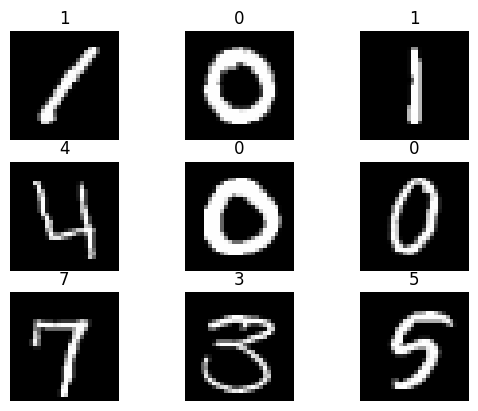

In [7]:
# plot the first 9 images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.title(y[i])
    plt.axis('off')
plt.show()

## data augementation

In [8]:
# data augementation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.2,
    shear_range=0.2
)

In [9]:
# fit the data
datagen.fit(X)

In [10]:
# Define the number of augmented samples you want to generate
desired_samples = 000

# Calculate the number of batches needed based on your batch size
batch_size = 32
num_batches_needed = desired_samples // batch_size
if desired_samples % batch_size!= 0:
    num_batches_needed += 1  # Ensure you generate enough batches to meet or exceed the desired number of samples

# Reset the counter for batches
batches = 0

# Collect augmented data
augmented_data = []
augmented_labels = []

for x_batch, y_batch in datagen.flow(X, y, batch_size=batch_size):
    augmented_data.append(x_batch)
    augmented_labels.append(y_batch)
    batches += 1
    
    # Stop the loop once the desired number of batches has been generated
    if batches >= num_batches_needed:
        break

# Concatenate the augmented data and labels
augmented_data = np.concatenate(augmented_data)
augmented_labels = np.concatenate(augmented_labels)

In [11]:
print(f"Generated {len(augmented_data)} augmented data samples.")

Generated 21024 augmented data samples.


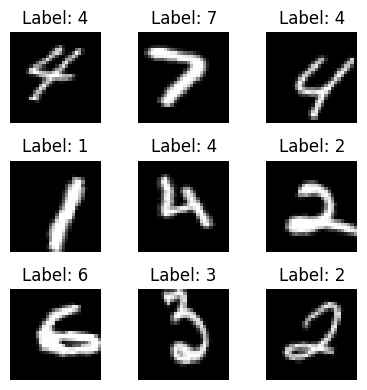

In [12]:
# Plot the first 9 images of the augmented data
fig, axs = plt.subplots(3, 3, figsize=(4, 4))
for i, ax in enumerate(axs.flat):
    ax.imshow(augmented_data[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {augmented_labels[i]}')
    ax.axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

In [13]:
# append the augmented data and labels to the original data
X = np.concatenate((X, augmented_data))
y = np.concatenate((y, augmented_labels))

In [14]:
print(f"New augmented dataset size: {len(X)}")

New augmented dataset size: 63024


## Model Training

In [15]:
# split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# # create a CNN model
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

# model = Sequential()
# model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
# model.add(MaxPooling2D(2))
# model.add(Conv2D(32, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D(2))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation='softmax'))

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
# more complex CNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax

model = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(96, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adamax(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 96)        55392     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 96)       384       
 hNormalization)                                                 
                                                        

In [19]:
# check gpu availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# check gpu memory usage
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
# define the early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [21]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, callbacks=[early_stopping])

Epoch 1/40
1576/1576 [==============================] - 24s 11ms/step - loss: 0.4349 - accuracy: 0.8651 - val_loss: 0.1519 - val_accuracy: 0.9517
Epoch 2/40
1576/1576 [==============================] - 15s 10ms/step - loss: 0.1864 - accuracy: 0.9424 - val_loss: 0.1227 - val_accuracy: 0.9594
Epoch 3/40
1576/1576 [==============================] - 15s 10ms/step - loss: 0.1372 - accuracy: 0.9575 - val_loss: 0.0957 - val_accuracy: 0.9698
Epoch 4/40
1576/1576 [==============================] - 16s 10ms/step - loss: 0.1104 - accuracy: 0.9658 - val_loss: 0.0806 - val_accuracy: 0.9742
Epoch 5/40
1576/1576 [==============================] - 17s 11ms/step - loss: 0.0892 - accuracy: 0.9730 - val_loss: 0.0774 - val_accuracy: 0.9749
Epoch 6/40
1576/1576 [==============================] - 16s 10ms/step - loss: 0.0781 - accuracy: 0.9759 - val_loss: 0.0735 - val_accuracy: 0.9755
Epoch 7/40
1576/1576 [==============================] - 16s 10ms/step - loss: 0.0662 - accuracy: 0.9789 - val_loss: 0.0773 -

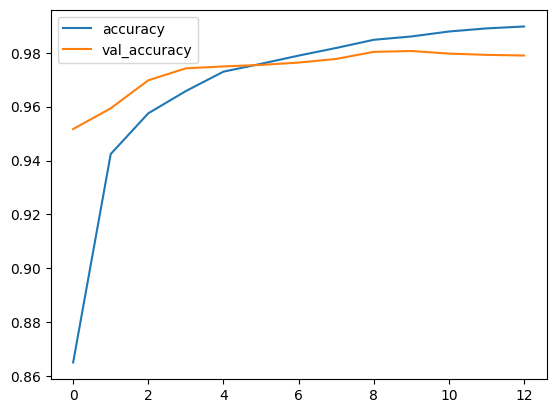

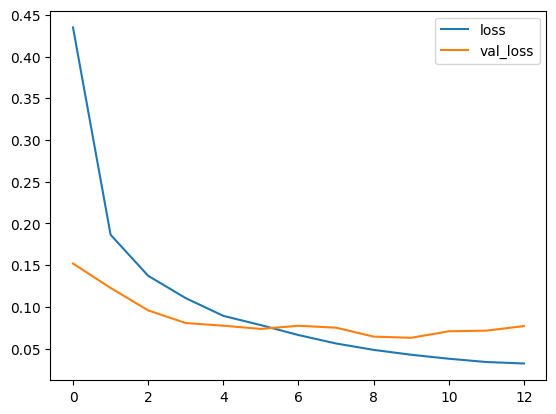

In [22]:
# plot the loss and accuracy
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [30]:
# save the cnn model
model.save('models\\cnn_model.h5')

In [31]:
# cnn metrics
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

394/394 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1232
           1       0.98      1.00      0.99      1435
           2       0.97      0.96      0.97      1272
           3       0.99      0.97      0.98      1343
           4       0.97      0.99      0.98      1210
           5       0.98      0.98      0.98      1112
           6       0.99      0.99      0.99      1251
           7       0.96      0.97      0.97      1320
           8       0.98      0.98      0.98      1216
           9       0.99      0.96      0.97      1214

    accuracy                           0.98     12605
   macro avg       0.98      0.98      0.98     12605
weighted avg       0.98      0.98      0.98     12605

[[1211    3    2    0    1    3    2    5    2    3]
 [   0 1429    1    0    1    0    1    2    1    0]
 [   2    7 1225    5    1    0    1   23    5    3]
 [   1    1   11 1304    0 

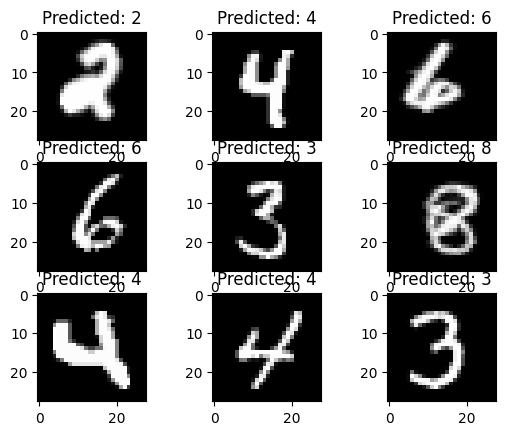

In [24]:
# plot the first 9 images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.title(f'Predicted: {np.argmax(y_pred[i])}')
plt.show()

## Making Submission

In [25]:
# load the test data
path = 'data\\test.csv'
df_sub = pd.read_csv(path)

In [26]:
X_sub = df_sub.values.reshape(-1, 28, 28, 1)

In [27]:
# make predictions
y_pred_sub = model.predict(X_sub)

875/875 [==============================] - 3s 4ms/step


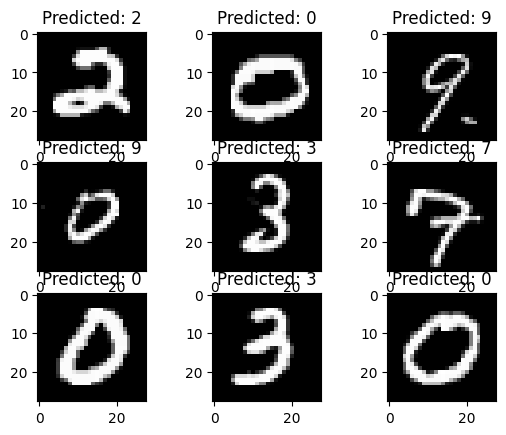

In [28]:
# plot the first 9 images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_sub[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.title(f'Predicted: {np.argmax(y_pred_sub[i])}')
plt.show()


In [29]:
# create a submission file
y_pred_sub = [np.argmax(y) for y in y_pred_sub]
df_submit = pd.DataFrame({'ImageId': range(1, len(y_pred_sub) + 1), 'Label': y_pred_sub})
df_submit.to_csv('submission.csv', index=False)